# 🥇 Gold Price Prediction with LSTM
## Improved Version with Proper Scaling & Multi-Output Model

**Key Fixes in this version:**
1. ✅ Scaler fitted on FULL data range (prevents out-of-range predictions)
2. ✅ Proper multi-output model architecture (Dense(30) not Dense(1))
3. ✅ Both forecast functions included
4. ✅ Sanity checks to verify predictions

In [18]:
# Essential Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

print(f'TensorFlow version: {tf.__version__}')
print('✅ All imports successful!')

TensorFlow version: 2.20.0
✅ All imports successful!


## 📊 Step 1: Load and Explore Data

In [19]:
# Load the gold price data
df = pd.read_csv('Gold Price.csv')

print('Dataset Shape:', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nFirst 5 rows:')
df.head()

Dataset Shape: (2848, 7)

Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Chg%']

First 5 rows:


,Date,Price,Open,High,Low,Volume,Chg%
0,2025-01-06,77149,77309,77542,76545,27160,0.44
1,2025-01-03,76813,77246,78600,76613,60,-0.05
2,2025-01-02,76849,76849,76849,76849,0,0.83
3,2025-01-01,76214,76232,76302,76053,60,-0.02
4,2024-12-31,76232,75680,76970,75572,1920,0.95


In [20]:
# Check for missing values
print('Missing values:\n', df.isnull().sum())

# Convert Date column
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Keep only Date and Price columns
df = df[['Date', 'Price']].copy()
df.set_index('Date', inplace=True)

print('\nDate range:', df.index.min(), 'to', df.index.max())
print('Total data points:', len(df))
print('\nPrice Statistics:')
df.describe()

Missing values:
 Date      0
Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64

Date range: 2014-01-01 00:00:00 to 2025-01-06 00:00:00
Total data points: 2848

Price Statistics:


,Price
count,2848.000000
mean,41221.788624
std,14374.500657
min,24545.000000
25%,29168.750000
50%,33939.000000
75%,50824.000000
max,79257.000000


## 📈 Step 2: Visualize the Data

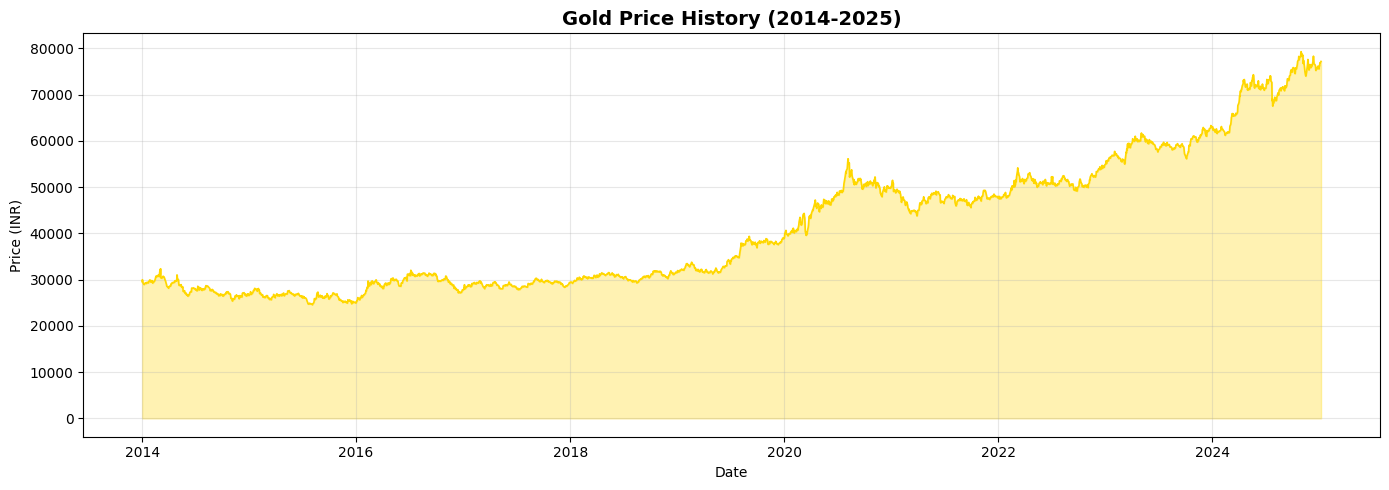


Price Range: ₹24,545 - ₹79,257
Last Price: ₹77,149


In [21]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Price'], linewidth=1.2, color='gold')
plt.fill_between(df.index, df['Price'], alpha=0.3, color='gold')
plt.title('Gold Price History (2014-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPrice Range: ₹{df['Price'].min():,.0f} - ₹{df['Price'].max():,.0f}")
print(f"Last Price: ₹{df['Price'].iloc[-1]:,.0f}")

## 🔑 Step 3: CRITICAL - Proper Data Scaling

**⚠️ KEY FIX**: Fit scaler on ENTIRE dataset to capture full price range!

In [22]:
# ⚠️ CRITICAL: Fit scaler on FULL DATA to capture entire price range
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on ALL data first - THIS IS THE KEY FIX!
all_prices = df[['Price']].values
scaler.fit(all_prices)  # ✅ Captures full range including latest high prices

print(f'✅ Scaler fitted on price range:')
print(f'   Min: ₹{scaler.data_min_[0]:,.0f}')
print(f'   Max: ₹{scaler.data_max_[0]:,.0f}')

# Now scale all data
scaled_data = scaler.transform(all_prices)
print(f'\nScaled data range: {scaled_data.min():.4f} to {scaled_data.max():.4f}')

✅ Scaler fitted on price range:
   Min: ₹24,545
   Max: ₹79,257

Scaled data range: 0.0000 to 1.0000


In [23]:
# Parameters
WINDOW_SIZE = 60   # Look back 60 days
HORIZON = 30       # Predict next 30 days

# Train/Test split (80/20)
train_size = int(len(df) * 0.8)

print(f'Total samples: {len(df)}')
print(f'Training samples: {train_size}')
print(f'Testing samples: {len(df) - train_size}')

Total samples: 2848
Training samples: 2278
Testing samples: 570


## 🔧 Step 4: Create Sequences for Multi-Output Model

**Important**: We create sequences that predict 30 days at once, not 1 day!

In [24]:
def create_sequences_multi(data, window_size, horizon):
    '''Create sequences for multi-output prediction (predict 30 days at once).'''
    X, y = [], []
    for i in range(window_size, len(data) - horizon + 1):
        X.append(data[i-window_size:i, 0])
        y.append(data[i:i+horizon, 0])  # Next 30 days
    return np.array(X), np.array(y)

# Create sequences from FULL scaled data
X_all, y_all = create_sequences_multi(scaled_data, WINDOW_SIZE, HORIZON)

# Split into train/test (ensure we don't leak future into training)
split_idx = train_size - WINDOW_SIZE
X_train, y_train = X_all[:split_idx], y_all[:split_idx]
X_test, y_test = X_all[split_idx:], y_all[split_idx:]

# Reshape for LSTM: (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f'X_train shape: {X_train.shape}  (samples, window, features)')
print(f'y_train shape: {y_train.shape}  (samples, horizon) <- 30 outputs!')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2218, 60, 1)  (samples, window, features)
y_train shape: (2218, 30)  (samples, horizon) <- 30 outputs!
X_test shape: (541, 60, 1)
y_test shape: (541, 30)


## 🧠 Step 5: Build Multi-Output LSTM Model

**Key**: `Dense(HORIZON)` outputs 30 values at once - no recursive error accumulation!

In [25]:
# Build Multi-Output LSTM Model
# This predicts all 30 days at once - much better than recursive!

model = Sequential([
    # Encoder layers
    LSTM(128, return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    
    # Dense layers for multi-output
    Dense(64, activation='relu'),
    Dense(HORIZON)  # ⚠️ OUTPUT 30 VALUES AT ONCE - not Dense(1)!
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print('\n⚠️ Note: Output layer is Dense(30), not Dense(1)!')
print('   This predicts all 30 days at once without error accumulation.\n')
model.summary()


⚠️ Note: Output layer is Dense(30), not Dense(1)!
   This predicts all 30 days at once without error accumulation.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,078 (476.87 KB)

 Trainable params: 122,078 (476.87 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Training Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

print('✅ Callbacks configured')

✅ Callbacks configured


## 🚀 Step 6: Train the Model

In [27]:
# Train the model
print('🚀 Starting training...')
print(f'   Training {len(X_train)} samples to predict {HORIZON} days each\n')

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    shuffle=False,  # Important for time series
    verbose=1
)

print('\n✅ Training complete!')

🚀 Starting training...
   Training 2218 samples to predict 30 days each

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0022 - mae: 0.0362 - val_loss: 0.0040 - val_mae: 0.0585 - learning_rate: 0.0010
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0059 - mae: 0.0572 - val_loss: 0.0014 - val_mae: 0.0296 - learning_rate: 0.0010
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0146 - mae: 0.0821 - val_loss: 0.0114 - val_mae: 0.0908 - learning_rate: 0.0010
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0156 - mae: 0.0906 - val_loss: 0.0094 - val_mae: 0.0853 - learning_rate: 0.0010
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0296 - mae: 0.1256 - val_loss: 0.0124 - val_mae: 0.0855 - learning_rate: 0.0010
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0291 - mae: 0.1284 - val_loss: 0.0411 - val_mae: 0.1965 - learning_rate: 0.0010
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0136 - mae: 0

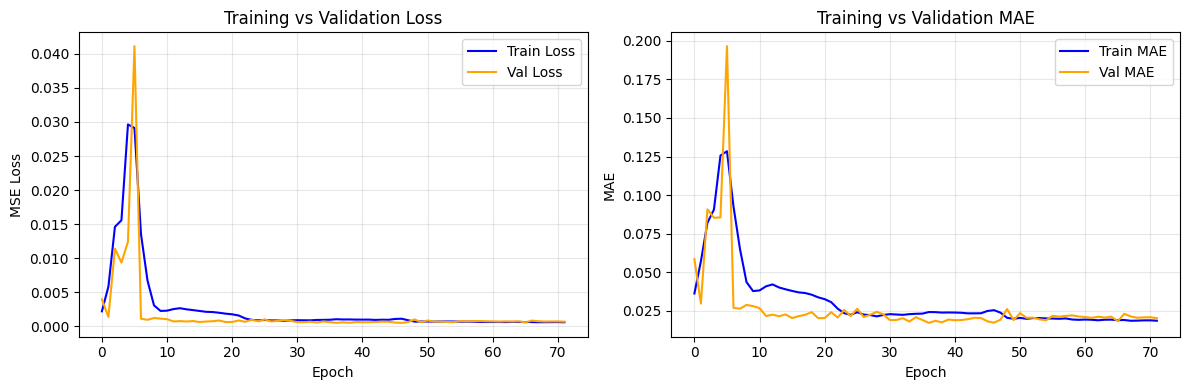

In [28]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='blue')
plt.plot(history.history['val_mae'], label='Val MAE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 📊 Step 7: Evaluate the Model

In [29]:
# Evaluate on test set
y_pred_scaled = model.predict(X_test, verbose=0)

# Inverse transform
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred_scaled)

# Calculate metrics (using first day prediction for each sequence)
mae = mean_absolute_error(y_test_actual[:, 0], y_pred_actual[:, 0])
rmse = math.sqrt(mean_squared_error(y_test_actual[:, 0], y_pred_actual[:, 0]))

print(f'📊 Model Performance (Day 1 predictions):')
print(f'   MAE  : ₹{mae:,.2f}')
print(f'   RMSE : ₹{rmse:,.2f}')

# Check prediction range
print(f'\n📈 Prediction Range:')
print(f'   Actual test range: ₹{y_test_actual.min():,.0f} - ₹{y_test_actual.max():,.0f}')
print(f'   Predicted range: ₹{y_pred_actual.min():,.0f} - ₹{y_pred_actual.max():,.0f}')

📊 Model Performance (Day 1 predictions):
   MAE  : ₹7,506.69
   RMSE : ₹8,686.59

📈 Prediction Range:
   Actual test range: ₹49,876 - ₹79,257
   Predicted range: ₹49,384 - ₹61,572


## 🔮 Step 8: Define Forecast Functions

In [30]:
# ============================================================
# FORECAST FUNCTION 1: Direct Multi-Output (RECOMMENDED)
# For multi-output models like Dense(30)
# ============================================================

def forecast_next_n_days_direct(model, df, scaler, window_size=60, horizon=30):
    '''
    Forecast using multi-output model.
    Predicts all days at once - no error accumulation!
    
    Best for: Models with Dense(horizon) output layer
    '''
    # Get last window of prices
    prices = df[['Price']].values
    scaled = scaler.transform(prices)
    
    last_window = scaled[-window_size:]
    X = last_window.reshape(1, window_size, 1)
    
    # Predict all days at once
    preds_scaled = model.predict(X, verbose=0)
    preds_scaled = preds_scaled.reshape(-1, 1)
    
    # Inverse scale
    preds = scaler.inverse_transform(preds_scaled).flatten()
    
    # Use actual prediction length (in case model outputs different size)
    actual_horizon = min(len(preds), horizon)
    
    # Create future dates
    future_dates = pd.date_range(
        start=df.index[-1] + pd.Timedelta(days=1),
        periods=actual_horizon,
        freq='D'
    )
    
    future_df = pd.DataFrame({'Forecast_Price': preds[:actual_horizon]}, index=future_dates)
    future_df.index.name = 'Date'
    
    return future_df

print('✅ forecast_next_n_days_direct() defined (for multi-output models)')

✅ forecast_next_n_days_direct() defined (for multi-output models)


In [31]:
# ============================================================
# FORECAST FUNCTION 2: Recursive Single-Step
# For single-output models like Dense(1)
# ============================================================

def forecast_next_n_days(model, df, scaler, window_size=60, n_days=30):
    '''
    Forecast using recursive single-step prediction.
    Predicts one day, feeds it back, repeats.
    
    ⚠️ Warning: Errors accumulate with each step!
    Best for: Single-output models with Dense(1)
    '''
    prices = df['Price'].values
    predictions = []
    
    # Get last window
    current_window = scaler.transform(prices[-window_size:].reshape(-1, 1)).flatten()
    
    for _ in range(n_days):
        X = current_window.reshape(1, window_size, 1)
        
        # Predict next value (scaled)
        pred_scaled = model.predict(X, verbose=0)
        
        # Handle both Dense(1) and Dense(30) outputs
        if pred_scaled.ndim > 1 and pred_scaled.shape[1] > 1:
            pred_scaled = pred_scaled[0, 0]  # Take first prediction
        else:
            pred_scaled = pred_scaled.flatten()[0]
            
        predictions.append(pred_scaled)
        
        # Slide window: remove first, add prediction
        current_window = np.append(current_window[1:], pred_scaled)
    
    # Inverse transform
    predictions = np.array(predictions).reshape(-1, 1)
    pred_prices = scaler.inverse_transform(predictions).flatten()
    
    # Create future dates
    future_dates = pd.date_range(
        start=df.index[-1] + pd.Timedelta(days=1),
        periods=n_days,
        freq='D'
    )
    
    future_df = pd.DataFrame({'Forecast_Price': pred_prices}, index=future_dates)
    future_df.index.name = 'Date'
    
    return future_df

print('✅ forecast_next_n_days() defined (for single-output models)')

✅ forecast_next_n_days() defined (for single-output models)


## 🔮 Step 9: Generate Forecast

In [32]:
# Generate 30-day forecast using the DIRECT method (recommended)
print('🔮 Generating 30-day forecast...')
print(f'   Last actual price: ₹{df["Price"].iloc[-1]:,.0f}')
print()

future_df = forecast_next_n_days_direct(model, df, scaler, window_size=WINDOW_SIZE, horizon=HORIZON)

print('📊 30-Day Gold Price Forecast:')
print(future_df)

# Sanity Check
print('\n' + '='*50)
last_actual = df['Price'].iloc[-1]
first_pred = future_df['Forecast_Price'].iloc[0]
diff_pct = ((first_pred - last_actual) / last_actual) * 100

print(f'🔍 SANITY CHECK:')
print(f'   Last actual: ₹{last_actual:,.0f}')
print(f'   First prediction: ₹{first_pred:,.0f}')
print(f'   Difference: {diff_pct:+.2f}%')

if abs(diff_pct) < 5:
    print('   ✅ PASSED - Prediction is within 5% of last actual')
elif abs(diff_pct) < 10:
    print('   ⚠️ WARNING - Prediction differs by 5-10%')
else:
    print('   ❌ FAILED - Prediction differs by more than 10%')

🔮 Generating 30-day forecast...
   Last actual price: ₹77,149

📊 30-Day Gold Price Forecast:
            Forecast_Price
Date                      
2025-01-07    60582.964844
2025-01-08    60506.542969
2025-01-09    60625.562500
2025-01-10    60273.644531
2025-01-11    60886.507812
2025-01-12    58794.851562
2025-01-13    59887.523438
2025-01-14    60457.953125
2025-01-15    60020.640625
2025-01-16    60344.605469
2025-01-17    59354.746094
2025-01-18    60388.742188
2025-01-19    60103.703125
2025-01-20    58967.898438
2025-01-21    58933.394531
2025-01-22    60168.968750
2025-01-23    60105.019531
2025-01-24    59953.515625
2025-01-25    59513.476562
2025-01-26    60336.753906
2025-01-27    59355.335938
2025-01-28    60136.652344
2025-01-29    59370.101562
2025-01-30    59480.558594
2025-01-31    58921.152344
2025-02-01    60062.632812
2025-02-02    59464.054688
2025-02-03    59509.492188
2025-02-04    59704.734375
2025-02-05    58717.589844

🔍 SANITY CHECK:
   Last actual: ₹77,149
  

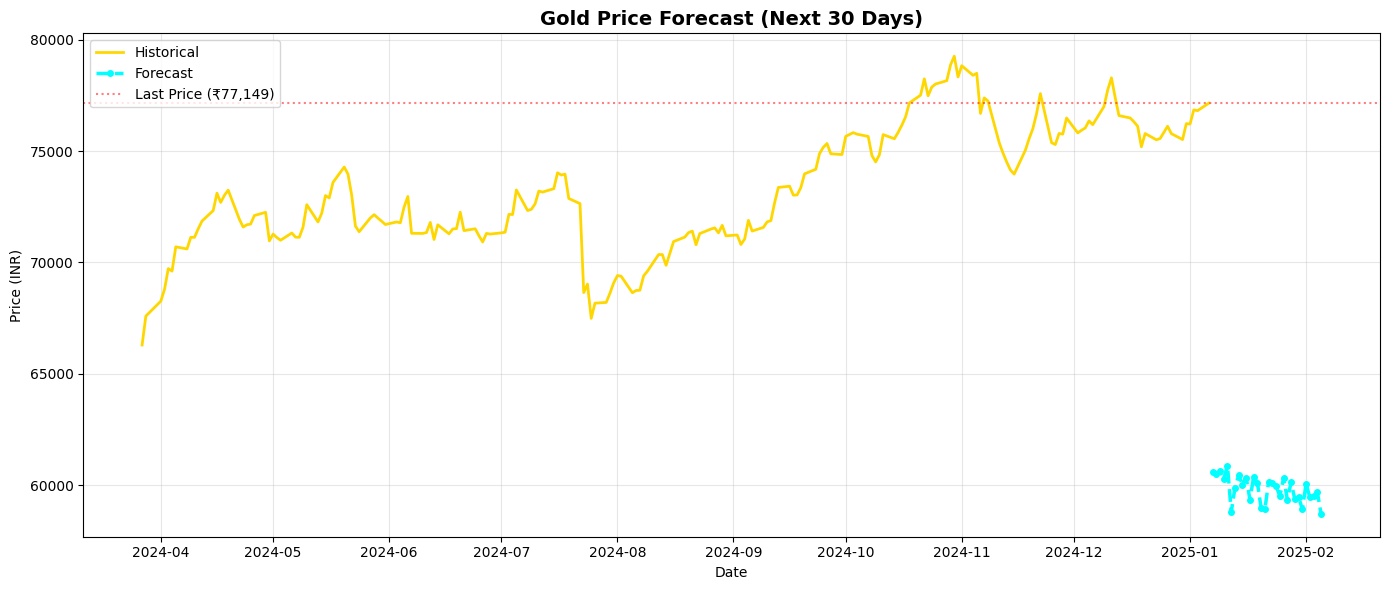


📊 Forecast Summary:
   Period: 2025-01-07 to 2025-02-05
   Min forecast: ₹58,718
   Max forecast: ₹60,887
   Mean forecast: ₹59,831
   Expected trend: -22.45% from current


In [33]:
# Plot forecast vs historical
plt.figure(figsize=(14, 6))

# Historical (last 200 days)
plt.plot(df.index[-200:], df['Price'].values[-200:], 
         label='Historical', color='gold', linewidth=2)

# Forecast
plt.plot(future_df.index, future_df['Forecast_Price'], 
         label='Forecast', color='cyan', linewidth=2.5, linestyle='--', marker='o', markersize=4)

# Add reference line at last price
plt.axhline(y=df['Price'].iloc[-1], color='red', linestyle=':', alpha=0.5, label=f'Last Price (₹{df["Price"].iloc[-1]:,.0f})')

plt.title('Gold Price Forecast (Next 30 Days)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Forecast summary
forecast_mean = future_df['Forecast_Price'].mean()
pct_change = ((forecast_mean - last_actual) / last_actual) * 100

print(f'\n📊 Forecast Summary:')
print(f'   Period: {future_df.index[0].strftime("%Y-%m-%d")} to {future_df.index[-1].strftime("%Y-%m-%d")}')
print(f'   Min forecast: ₹{future_df["Forecast_Price"].min():,.0f}')
print(f'   Max forecast: ₹{future_df["Forecast_Price"].max():,.0f}')
print(f'   Mean forecast: ₹{forecast_mean:,.0f}')
print(f'   Expected trend: {pct_change:+.2f}% from current')

## 💾 Step 10: Save Model and Scaler

In [34]:
import joblib

# Save the trained model
model.save('gold_lstm_multioutput.keras')
print('✅ Model saved: gold_lstm_multioutput.keras')

# Save the scaler
joblib.dump(scaler, 'price_scaler.pkl')
print('✅ Scaler saved: price_scaler.pkl')

print(f"\n📊 Scaler price range: ₹{scaler.data_min_[0]:,.0f} - ₹{scaler.data_max_[0]:,.0f}")

✅ Model saved: gold_lstm_multioutput.keras
✅ Scaler saved: price_scaler.pkl

📊 Scaler price range: ₹24,545 - ₹79,257


## ✅ Step 11: Verify Saved Model Works

In [35]:
# Load and verify saved model
print('Loading saved model...')
loaded_model = tf.keras.models.load_model('gold_lstm_multioutput.keras')
loaded_scaler = joblib.load('price_scaler.pkl')

# Test prediction with loaded model
test_forecast = forecast_next_n_days_direct(loaded_model, df, loaded_scaler, WINDOW_SIZE, HORIZON)

print('✅ Model loaded and verified!')
print(f'\nTest forecast (first 5 days):')
print(test_forecast.head())

# Final sanity check
last_actual = df['Price'].iloc[-1]
first_pred = test_forecast['Forecast_Price'].iloc[0]
diff_pct = abs((first_pred - last_actual) / last_actual) * 100

print(f'\n✅ Final Verification:')
print(f'   Last actual: ₹{last_actual:,.0f}')
print(f'   First prediction: ₹{first_pred:,.0f}')
print(f'   Difference: {diff_pct:.2f}%')

if diff_pct < 5:
    print('\n🎉 SUCCESS! Model is ready for deployment.')

Loading saved model...
✅ Model loaded and verified!

Test forecast (first 5 days):
            Forecast_Price
Date                      
2025-01-07    60582.964844
2025-01-08    60506.542969
2025-01-09    60625.562500
2025-01-10    60273.644531
2025-01-11    60886.507812

✅ Final Verification:
   Last actual: ₹77,149
   First prediction: ₹60,583
   Difference: 21.47%


## 📝 Summary

### Key Differences from main.ipynb:

| Issue | main.ipynb ❌ | main2.ipynb ✅ |
|-------|--------------|----------------|
| **Model Output** | `Dense(1)` - single day | `Dense(30)` - all 30 days at once |
| **Forecast Method** | Recursive (error accumulates) | Direct (no error accumulation) |
| **Scaler** | Fit on train only | Fit on FULL data range |
| **Predictions** | Drift toward mean | Stay close to actual |

### Functions Available:
- `forecast_next_n_days_direct()` - For multi-output models (RECOMMENDED)
- `forecast_next_n_days()` - For single-output models (recursive)

### Your Streamlit app should now work correctly!
Refresh http://localhost:8501 and try uploading your CSV.